In [1]:
from cell_mrcnn.data import get_channel_paths
from cell_mrcnn import __file__ as src_path
from os.path import join, split, isdir
from os import mkdir
from glob import glob
from cell_mrcnn.utils import get_well_and_pos, calc_layers, convert_to_bit8
from skimage.io import imread
import tensorflow as tf
from cell_mrcnn import cell
import pandas as pd
import numpy as np
import cell_mrcnn.model as modellib
from PIL import Image
from datetime import datetime
from matplotlib import pyplot as plt
ROOT_DIR = src_path.split('src')[0]
MODEL_DIR = join(ROOT_DIR, "logs")
data_dir = join(ROOT_DIR, 'data')
dataset_dir = join(ROOT_DIR, 'data/20201112-CB2-1wt-2Q63R-3L133i-4Cer L10/2020-11-12/1340_cellm/composite')
config = cell.CellInferenceConfig()

Using TensorFlow backend.


In [2]:
wells = ['A01', 'A02', 'A03', 'B01', 'B02', 'B03']

# get the CB2 (w2) channel paths for each well
w2_paths = get_channel_paths(join(data_dir, '20201112-CB2-1wt-2Q63R-3L133i-4Cer L10/2020-11-12/1340_cellm/TimePoint_1'),'w2', wells)
w2_path_dict = {}
# get the composite image paths for mask prediction  
composite_image_paths = glob(join(dataset_dir, '*.png'))
mask_path_dict = {}
# initialise other dicts
result_dict = {}
df_dict = {}
for well in wells:
    w2_path_dict[well] = {}
    mask_path_dict[well] = {}
    result_dict[well] = {}
    df_dict[well] = pd.DataFrame()
    
for path in w2_paths:
    well, pos = get_well_and_pos(path)
    w2_path_dict[well][pos] = path

for path in composite_image_paths:
    tail = split(path)[1].split('.')[0]
    well, pos = tail.split('s')
    mask_path_dict[well][pos] = path

In [3]:
DEVICE = "/gpu:0"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                                      config=config)
    weights_path = join(ROOT_DIR,"logs/cell20201123T1456/mask_rcnn_cell_0017.h5")
    print("Loading weights ", weights_path)
    model.load_weights(weights_path, by_name=True)

for i, well in enumerate(wells):
    for j,(pos, path) in enumerate(w2_path_dict[well].items()):
        print('\r{}/{} well: {}/{} position...'.format(i+1, len(wells), j+1, len(w2_path_dict[well].items())), end='')
        layers_image = imread(path)
        mask_image = imread(mask_path_dict[well][pos])
        
        mask_image = mask_image[:,:,(0,2)]
            
        results = model.detect([mask_image], verbose=0)[0]
        result_dict[well][pos] = results
        layers = calc_layers(layers_image, results['masks'])
        df = pd.DataFrame(layers).T
        df_dict[well] = pd.concat([df_dict[well], df], axis=1, ignore_index = True)
    df_dict[well]['mean'] = df_dict[well].mean(axis=1)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  /home/miska/repos/cell_mrcnn/logs/cell20201123T1456/mask_rcnn_cell_0017.h5






Re-starting from epoch 17
6/6 well: 25/25 position...

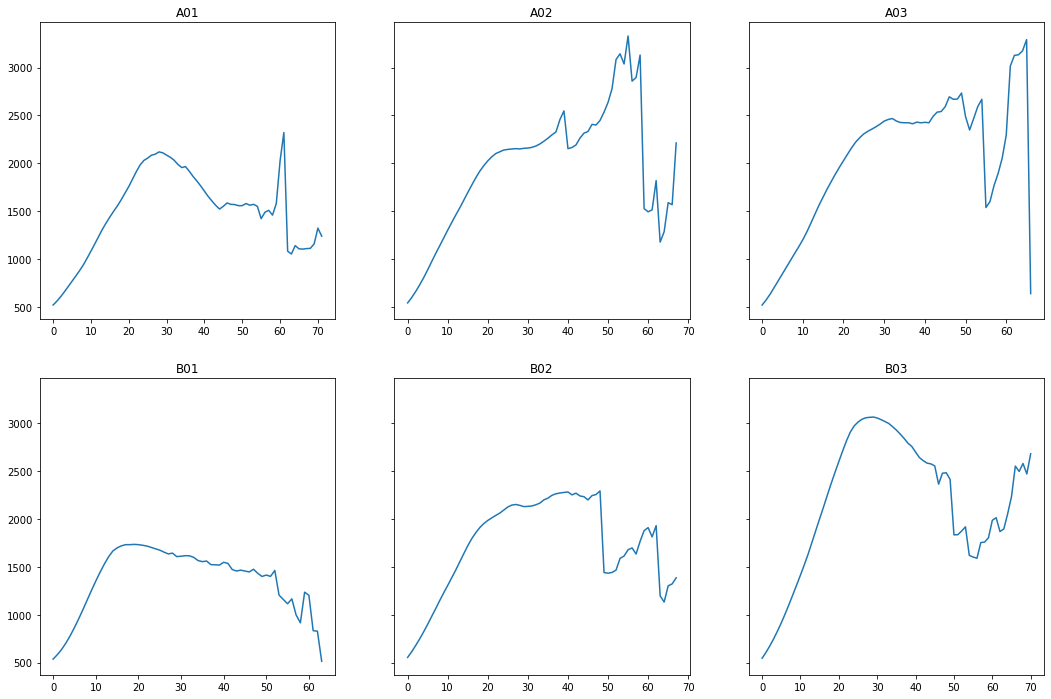

In [4]:
rows=2; cols=3; size = 6
fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows), sharey = True)
row, col = 0, 0
for j, well in enumerate(wells):
    ax[row, col].plot(np.arange(len(df_dict[well]['mean'])), df_dict[well]['mean'])
    ax[row, col].set_title(well)
    col += 1
    if (j+1) % 3 == 0:
        row += 1
        col = 0

In [5]:
# save the results
results_dir = join(ROOT_DIR, 'results')
if not isdir(results_dir):
    mkdir(results_dir)
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
output_folder = join(results_dir, date)
if not isdir(output_folder):
    mkdir(output_folder)
for well in result_dict.keys():
    well_dir = join(output_folder, well)
    if not isdir(well_dir):
        mkdir(well_dir)
    with open(join(well_dir, 'results.csv'), 'w') as f:
        f.write(df_dict[well].to_csv())
    for pos, r in result_dict[well].items():
        for m in range(r['masks'].shape[2]):
            mask_ = Image.fromarray((r['masks'][:,:,m]*255).astype(np.uint8),
                                    mode = 'L')
            mask_ = mask_.convert(mode='1')
            mask_.save(join(well_dir, pos + '_mask_' + str(m) +
                       '.png'))